In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 这一行注释掉就是使用gpu，不注释就是使用cpu
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time

d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [3]:

class VPINN:
    def __init__(self, X_u, u, X_quad, W_x_quad, Y_quad, W_y_quad,\
                 F_exact_total, grid_x, grid_y, var_form, \
                 layers, LR, lossb_weight, activation):
        self.x         = X_u[:, 0:1]
        self.y         = X_u[:, 1:2]
        self.u         = u
        self.xquad     = X_quad    # 不需要训练点(xf, f) 只需要求积点和边界点
        self.yquad     = Y_quad
        self.wquad_x   = W_x_quad
        self.wquad_y   = W_y_quad
        self.F_ext_total = F_exact_total
        self.grid_x    = grid_x
        self.grid_y    = grid_y
        self.var_form  = var_form
        self.activation= activation
        self.NEx       = grid_x.shape[0] - 1
        self.NEy       = grid_y.shape[0] - 1
        self.total_record = []

        self.x_tf   = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.y_tf   = tf.placeholder(tf.float64, shape=[None, self.y.shape[1]])
        self.u_tf   = tf.placeholder(tf.float64, shape=[None, self.u.shape[1]])

        self.weights, self.biases = self.initialize_NN(layers)
        self.u_NN_pred = self.net_u(self.x_tf, self.y_tf)   # 边界点预测值

        self.lossb  = tf.reduce_mean(tf.square(self.u_tf - self.u_NN_pred))
        self.lossv  = self.variational_loss()
        self.loss   = lossb_weight * self.lossb + self.lossv

        self.LR = LR
        self.optimizer_Adam = tf.train.AdamOptimizer(self.LR)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        self.sess = tf.Session()
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim), dtype=np.float64)
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float64), dtype=tf.float64)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers-2):
            W = weights[l]
            b = biases[l]
            H = self.activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, y):
        u = self.neural_net(tf.concat([x, y], 1), self.weights, self.biases)
        return u

    def net_du(self, x, y):
        u    = self.net_u(x, y)
        d1ux = tf.gradients(u, x)[0]
        d1uy = tf.gradients(u, y)[0]
        d2ux = tf.gradients(d1ux, x)[0]
        d2uy = tf.gradients(d1uy, y)[0]
        return d1ux, d2ux, d1uy, d2uy

    # 构造测试函数集
    def Test_fcn(self, N_test, x):
        test_total = []
        for n in range(1, N_test+1):
            test = Jacobi(n+1, 0, 0, x) - Jacobi(n-1, 0, 0, x)
            test_total.append(test)
        return np.asarray(test_total)

    # 返回测试函数的一阶和二阶微分
    def dTest_fcn(self, N_test, x):
        d1test_total = []
        d2test_total = []
        for n in range(1, N_test+1):
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
        return np.asarray(d1test_total), np.asarray(d2test_total)

    # variational loss
    def variational_loss(self):
        varloss_total = 0
        for e_y in range(self.NEy):
            for e_x in range(self.NEx):
                F_ext_element  = self.F_ext_total[e_y*self.NEy + e_x]     # 定位子区域
                Ntest_element  = int(np.sqrt(np.shape(F_ext_element)[0])) # 子区域的测试函数个数 x=y
                x_quad_element = tf.constant(self.grid_x[e_x] + \
                                 (self.grid_x[e_x + 1] - self.grid_x[e_x]) / 2*(self.xquad+1))
                jacobian_x     = (self.grid_x[e_x + 1] - self.grid_x[e_x]) / 2
                # 测试函数及其微分 global
                testx_quad_element = self.Test_fcn(Ntest_element, self.xquad)
                d1testx_quad_element, d2testx_quad_element = self.dTest_fcn(Ntest_element, self.xquad)

                y_quad_element = tf.constant(self.grid_y[e_y] + \
                                 (self.grid_y[e_y + 1] - self.grid_y[e_y]) / 2*(self.yquad+1))
                jacobian_y     = (self.grid_y[e_y + 1] - self.grid_y[e_y]) / 2
                # 测试函数及其微分
                testy_quad_element = self.Test_fcn(Ntest_element, self.yquad)
                d1testy_quad_element, d2testy_quad_element = self.dTest_fcn(Ntest_element, self.yquad)
                # PDE及其微分
                # u_NN_quad_element = self.net_u(x_quad_element)
                d1ux_NN_quad_element, d2ux_NN_quad_element, \
                d1uy_NN_quad_element, d2uy_NN_quad_element = self.net_du(x_quad_element, y_quad_element)

                if self.var_form == 1:
                    # d2ux_NN_quad_element.shape  = (10, 1)
                    # testx_quad_element.shape    = (5, 10, 1)
                    # self.wquad_x.shape          = (10, 1)
                    U_NN_element_x = []
                    U_NN_element_y = []
                    for phi_y in testy_quad_element:
                        for phi_x in testx_quad_element:
                            inte1_x = jacobian_x*tf.reduce_sum(self.wquad_x*d2ux_NN_quad_element*phi_x)
                            inte1_y = jacobian_x*tf.reduce_sum(self.wquad_x*d2uy_NN_quad_element*phi_x)
                            inte2_x = jacobian_y*tf.reduce_sum(self.wquad_y*inte1_x*phi_y)
                            inte2_y = jacobian_y*tf.reduce_sum(self.wquad_y*inte1_y*phi_y)
                            U_NN_element_x.append(inte2_x)
                            U_NN_element_y.append(inte2_y)
                    U_NN_element_x = tf.reshape(U_NN_element_x, (-1, 1))
                    U_NN_element_y = tf.reshape(U_NN_element_y, (-1, 1))
                    U_NN_element   = U_NN_element_x + U_NN_element_y

                if self.var_form == 2:
                    # d1testx_quad_element.shape = (5, 10, 1)
                    U_NN_element_x = []
                    U_NN_element_y = []
                    for phi_y in testy_quad_element:
                        for phi_x_d1 in d1testx_quad_element:
                            inte1_x = tf.reduce_sum(self.wquad_x*d1ux_NN_quad_element*phi_x_d1)
                            inte2_x = -tf.reduce_sum(self.wquad_y*inte1_x*phi_y)
                            U_NN_element_x.append(inte2_x)
                    U_NN_element_x = tf.reshape(U_NN_element_x, (-1, 1))
                    for phi_x in testx_quad_element:
                        for phi_y_d1 in d1testy_quad_element:
                            inte1_y = tf.reduce_sum(self.wquad_y*d1uy_NN_quad_element*phi_y_d1)
                            inte2_y = -tf.reduce_sum(self.wquad_x*inte1_y*phi_x)
                            U_NN_element_y.append(inte2_y)
                    U_NN_element_y = tf.reshape(U_NN_element_y, (-1, 1))
                    U_NN_element   = U_NN_element_x + U_NN_element_y

                Res_NN_element = U_NN_element - F_ext_element
                loss_element   = tf.reduce_mean(tf.square(Res_NN_element))
                varloss_total += loss_element
        return varloss_total

    def predict(self, x, y):
        u_pred  = self.sess.run(self.u_NN_pred, {self.x_tf: x, self.y_tf: y})
        return u_pred

    def train(self, nIter, tresh):
        tf_dict = {self.x_tf: self.x, self.y_tf : self.y, self.u_tf: self.u}
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value  = self.sess.run(self.loss, tf_dict)
            loss_valueb = self.sess.run(self.lossb, tf_dict)
            loss_valuev = self.sess.run(self.lossv, tf_dict)
            self.total_record.append(np.array([it, loss_value]))
            if loss_value < tresh:
                print('It: %d, Loss: %.3e' % (it, loss_value))
                break
            if it % 100 == 0:
                elapsed = time.time() - start_time
                str_print = 'It: %d, Lossb: %.3e, Lossv: %.3e, Time: %.2f'
                print(str_print % (it, loss_valueb, loss_valuev, elapsed))
        end_time = time.time()
        print("training time %f, loss %f"%(end_time - start_time, loss_value))


In [4]:
LR = 0.001
Opt_Niter = 40000
Opt_tresh = 2e-32
var_form  = 1
NEx = 2
NEy = 2
Net_layer  = [2] + [5] * 3 + [1]
activation = tf.tanh
Nx_testfcn = 5
Ny_testfcn = 5
Nx_Quad = 10
Ny_Quad = 10
lossb_weight = 10
N_u_train    = 20
N_test       = 100
#++++++++++++++++++++++++++++
# 测试函数迭代 高斯雅各比迭代 测试函数彼此正交 最终总共构造N_testfcn个测试函数
def Test_fcn(n, x):
   test  = Jacobi(n+1, 0, 0, x) - Jacobi(n-1, 0, 0, x)
   return test
#++++++++++++++++++++++++++++
def u_ext(x,y):  #steep solution u(x)
    u = 2*(1+y)/((3+x)**2+(1+y)**2)
    return u
#++++++++++++++++++++++++++++
[x_quad, w_quad_x] = GaussLobattoJacobiWeights(Nx_Quad, 0, 0)
testfcn_x = np.asarray([Test_fcn(n, x_quad)  for n in range(1, Nx_testfcn+1)])
[y_quad, w_quad_y] = GaussLobattoJacobiWeights(Ny_Quad, 0, 0)
testfcn_y = np.asarray([Test_fcn(n, y_quad)  for n in range(1, Ny_testfcn+1)])

In [5]:
# 区域划分
[x_l, x_r] = [-1, 1]
delta_x = (x_r - x_l) / NEx
# 区域网格点 eg. 均分为两个区域[-1, 0, 1]
grid_x  = np.asarray([x_l + i*delta_x for i in range(NEx+1)])
# 每个区域内测试函数的数目，目前都一样，结果只取决于区域内的求积点
Nx_testfcn_total = np.array((len(grid_x) - 1)*[Nx_testfcn])
[y_l, y_h] = [-1, 1]
delta_y = (y_h - y_l) / NEy
grid_y  = np.asarray([y_l + i*delta_y for i in range(NEy+1)])
Ny_testfcn_total = np.array((len(grid_y) - 1)*[Ny_testfcn])
# 计算Fk NEx * NEy 个区域
F_ext = np.array((Nx_testfcn*Ny_testfcn) * [0])[:, None]
F_ext_total = np.tile(F_ext, (4, 1)).reshape(-1, 25, 1)

In [6]:
#++++++++++++++++++++++++++++
# Training points
# 此问题有四条边界
def getBC(N_u_train, x_l, x_r, y_l, y_h):
    # x = 1
    X_u_train_x1 = np.array(N_u_train * [1])[:, None]
    X_u_train_y1 = np.linspace(y_l, y_h, N_u_train)[:, None]
    X_u_train_1  = np.hstack((X_u_train_x1, X_u_train_y1))
    u_train_1    = u_ext(X_u_train_x1, X_u_train_y1)
    # x = -1
    X_u_train_x2 = np.array(N_u_train * [-1])[:, None]
    X_u_train_y2 = np.linspace(y_l, y_h, N_u_train)[:, None]
    X_u_train_2  = np.hstack((X_u_train_x2, X_u_train_y2))
    u_train_2    = u_ext(X_u_train_x2, X_u_train_y2)
    # y = 1
    X_u_train_x3 = np.linspace(x_l, x_r, N_u_train)[:, None]
    X_u_train_y3 = np.array(N_u_train * [1])[:, None]
    X_u_train_3  = np.hstack((X_u_train_x3, X_u_train_y3))
    u_train_3    = u_ext(X_u_train_x3, X_u_train_y3)
    # y = -1
    X_u_train_x4 = np.linspace(x_l, x_r, N_u_train)[:, None]
    X_u_train_y4 = np.array(N_u_train * [-1])[:, None]
    X_u_train_4  = np.hstack((X_u_train_x4, X_u_train_y4))
    u_train_4    = u_ext(X_u_train_x4, X_u_train_y4)
    # 合并
    X_u_train    = np.vstack((X_u_train_1, X_u_train_2, \
                              X_u_train_3, X_u_train_4))
    u_train      = np.vstack((u_train_1, u_train_2,\
                              u_train_3, u_train_4))
    return X_u_train, u_train

X_u_train, u_train = getBC(N_u_train, x_l, x_r, y_l, y_h)
#++++++++++++++++++++++++++++
# Quadrature points
X_quad   = x_quad[:, None]
W_quad_x = w_quad_x[:, None]
Y_quad   = y_quad[:, None]
W_quad_y = w_quad_y[:, None]
#++++++++++++++++++++++++++++
# Test point
x = np.linspace(x_l, x_r, N_test)
y = np.linspace(y_l, y_h, N_test)
X, Y = np.meshgrid(x, y)
u = 2 * (1 + Y) / ((3 + X) ** 2 + (1 + Y) ** 2)
data = np.hstack([X.flatten()[:, None], Y.flatten()[:, None]])

In [7]:
model = VPINN(X_u_train, u_train, X_quad, W_quad_x, Y_quad, W_quad_y,\
              F_ext_total, grid_x, grid_y, var_form, Net_layer, \
              LR, lossb_weight, activation)
model.train(Opt_Niter, Opt_tresh)
total_record = model.total_record
u_pred = model.predict(X.flatten()[:, None], Y.flatten()[:, None])
U_pred = griddata(data, u_pred.flatten(), (X, Y), method='cubic')
relative_L2 = np.linalg.norm(u_pred - u.flatten()[:, None]) / np.linalg.norm(u.flatten()[:, None])
print(relative_L2)

It: 0, Lossb: 6.524e-02, Lossv: 2.018e-04, Time: 14.88
It: 100, Lossb: 5.646e-03, Lossv: 7.554e-03, Time: 15.72
It: 200, Lossb: 4.620e-03, Lossv: 5.212e-03, Time: 16.44
It: 300, Lossb: 3.740e-03, Lossv: 3.891e-03, Time: 17.36
It: 400, Lossb: 2.593e-03, Lossv: 3.147e-03, Time: 18.07
It: 500, Lossb: 1.058e-03, Lossv: 3.753e-03, Time: 18.75
It: 600, Lossb: 3.530e-04, Lossv: 5.028e-03, Time: 19.43
It: 700, Lossb: 2.183e-04, Lossv: 4.640e-03, Time: 20.09
It: 800, Lossb: 1.536e-04, Lossv: 3.695e-03, Time: 20.75
It: 900, Lossb: 1.072e-04, Lossv: 2.698e-03, Time: 21.43
It: 1000, Lossb: 7.699e-05, Lossv: 1.889e-03, Time: 22.18
It: 1100, Lossb: 5.873e-05, Lossv: 1.340e-03, Time: 22.85
It: 1200, Lossb: 4.808e-05, Lossv: 9.916e-04, Time: 23.57
It: 1300, Lossb: 4.168e-05, Lossv: 7.687e-04, Time: 24.26
It: 1400, Lossb: 3.747e-05, Lossv: 6.220e-04, Time: 24.93
It: 1500, Lossb: 3.440e-05, Lossv: 5.225e-04, Time: 25.61
It: 1600, Lossb: 3.198e-05, Lossv: 4.535e-04, Time: 26.29
It: 1700, Lossb: 2.994e-05

d:\programfile\python3.7.4\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
d:\programfile\python3.7.4\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
d:\programfile\python3.7.4\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated

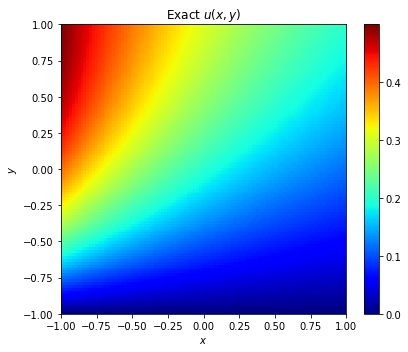

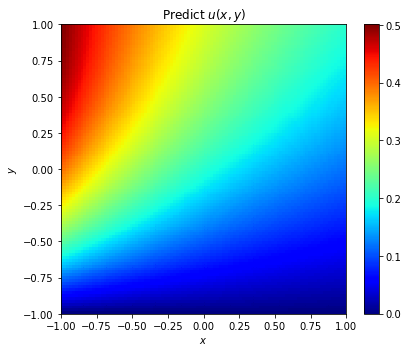

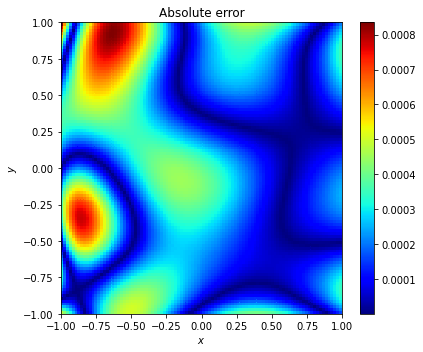

In [8]:
fig = plt.figure(figsize=(6, 5))
plt.pcolor(Y, X, u.T, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Exact $u(x,y)$')
plt.colorbar()
plt.tight_layout()
plt.savefig('./Results/2d/Exact u.pdf')

fig = plt.figure(figsize=(6, 5))
plt.pcolor(Y, X, U_pred.T, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Predict $u(x,y)$')
plt.colorbar()
plt.tight_layout()
plt.savefig('./Results/2d/Pred u.pdf')

fig = plt.figure(figsize=(6, 5))
plt.pcolor(Y, X, np.abs(U_pred.T - u.T), cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./Results/2d/Absolute error.pdf')
plt.show()
